# Data Analysis

## Imports

Importamos las librerías y parámetros que necesitaremos en la ejecución del Notebook.

In [1]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from mgmtfm import clean
from wordcloud import WordCloud
import matplotlib.pyplot as plt


pd.set_option('max_rows',9999)
pd.set_option('max_columns', 9999)
pd.set_option('display.max_colwidth', 500)


print("Notebook ejecutado el {}.".format(datetime.now().strftime("%d-%m-%Y")))

Using TensorFlow backend.


Notebook ejecutado el 12-11-2019.


## Carga de datos

El <i>core</i> de nuestros datos son las llamadas en sí. Actualmente disponemos de grabaciones de un 20% de las llamadas de las que se transcriben un 20% (lo que supone un 4% del total), estas llamadas llegan mediante un proceso <i>batch</i>. En un futuro se espera disponer del 100% de las transcripciones en  <i>real-time</i>.


Cargamos el dataset tal y como lo recibimos del sistema de transcripciones y visualizamos los campos: 

In [2]:
verint_raw = pd.read_parquet('/data/datasets/input_data/verint_dataset.parquet')
verint_raw.head(1)

co_llamada_verint                  ucid  \
0  9136040272670004051  00028114201559548193   

                              mediaid           datecreated  \
0  2019060307520691001241579770827600  2019-09-05T15:45:48Z   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             plaintext  \
0  BUENOS DÍAS SOY MARINA HABLA DÍGAME PUEDO\nAYUDARLE BUENOS DÍAS MARINA EN MIRA UN TELÉFONO APLACE EN LA TIENDA MOVISTAR\nY TUVE\nTE NECESITO ME PODRÁS MIRAR CUANTOS PLAZOS ME QUEDAN POR PAGAR\nY Y\nTERMINAR DE PAGAR\nANTES Y\nSIETE\nA VER SI APARECE A VER YO AQUÍ VEO LA FACTURAS OFRECÍ APARECEN FACTURAS Y ME PUEDO INDICAR Y LO DE LOS SI LO PUEDE PAGAR ESO TENDRÍA HABLO CON LA FINANCIERA VALE DIGAMOS A VERLO DÍGAME EL NÚMERO TELÉFONO ESTÁ EN LA LÍNEA SEIS SEIS UNO\nDOS SIETE SIETE CERO UNO UN...   

                  audio_start_time             agent_name        ani  \
0 2019-06-03 09:52:06.910000+00:00  Marina Calle, UC54653  607068277   

   audio_ch_num  audio_module_num          audio_start_time_gmt  \
0      12415797            708276  2019-06-03T07:52:06.91+02:00   

          audio_start_time_gmt1  \
0  2019-06-03T07:52:06.91+02:00   

                                                                           cd1  \
0  005#91234#001#1004#607068277#661274115#SI#GR#CO#NI#SI#00028114201559548193#   

     cd2   cd3    cd4        cd5      cd6 cd7 cd8 cd9 cd10 cd11 cd12 cd14  \
0  91234  1004  91234  661274115  2166504   L      GR                       

  cd15 cd16 cd17 cd18            cd19      cd20  cd21        cd22 cd23 cd24  \
0                      GRP_EUR_Malaga  NULL;CAS  4S1R  Sur-Malaga   SI    0   

  cd25 cd26 cd27 cd28 cd29 cd30 cd31 cd32 cd33 cd34 cd35 cd36 cd37 cd38 cd39  \
0   99                                                                         

  cd40 cd41 cd42 cd43 cd44 cd45 cd46 cd47 cd48 cd49 cd50 cd51 cd52 cd53 cd54  \
0                                                 0    0                       

  cd55 cd56 cd57 cd58 cd59 cd60 cd61 cd62 cd63 cd64 cd65 cd66 cd67 cd68 cd69  \
0                                                                              

  cd70 cd71 cd72 cd73 cd74 cd75 cd  direction     dnis  duration_seconds  \
0                        0    0             1  2104504               202   

  extension language_code          local_audio_end_time  \
0   2123572         es-ES  2019-06-03T09:55:28.91+02:00   

         local_audio_start_time num_of_agent_cross num_of_other_cross  \
0  2019-06-03T09:52:06.91+02:00                  0                  0   

  number_of_conferences number_of_holds number_of_transfers pbx_login_id  \
0                  None            None                None      2173618   

  pcd10_value pcd11_value pcd12_value pcd13_value pcd14_value pcd15_value  \
0           0           0           0           0           0           0   

  pcd1_value pcd2_value pcd3_value pcd4_value pcd5_value pcd6_value  \
0  708000182   40000293   40000024  708000259   40000928          0   

  pcd7_value pcd8_value pcd9_value percent_of_agent_call  \
0          0          0          0                 [129]   

  percent_of_mutual_silence percent_of_other_call personal_id        sid  \
0                        42                    30    40212696  136131807   

   site_id       source_db string_extension switch_call_id total_hold_time  \
0      708  CentralContact          2123572            975                   

                       transaction_id wrapup_time wrapup_time_in_seconds  \
0  2019060307520691001241579770827600    00:00:00                      0   

 

Vemos los campos más importantes de nuestro Dataset (que, a priori, pueden ser de utilidad): 

<ul>
<li><b>co_llamada_verint</b>:  Código de la llamada en el sistema, nos servirá para identificar de manera unívoca la transcripción.</li>
<li><b>ucid</b>:  Código unívoco de la llamada.</li>
<li><b>fx_evento</b>: Fecha del evento.  </li>
<li><b>it_llamada</b>: Timestamp del evento.  </li>  
<li><b>datecreated</b>: Timestamp en el que se crea la transcripción.  </li>
<li><b>plaintext</b>: Transcripción de la llamada en texto plano.</li>
<li><b>audio_start_time</b>: Hora de inicio del audio. Formato UTC.</li>
<li><b>cd22</b>: Zona desde la que se ha realizado la llamada. </li>
<li><b>no_destino_pa</b>: Código IVR que categoriza la llamada en función de las opciones que elige el usuario al llamar. </li>
<li><b>duration</b>: Duración de la llamada.</li>
</ul>

Aunque existen más campos, estos parece que no estan relacionados con nuestro caso de uso.

Nos quedamos con parte de estos campos, para realizar un análisis previo. Y vemos el número total de llamadas disponibles:

In [3]:
verint = verint_raw[['co_llamada_verint','ucid','fx_evento','it_llamada','duration', 'plaintext', 'no_destino_pa']]
verint.plaintext = verint.plaintext.str.lower()
print(verint.count())
verint.head(1)

co_llamada_verint    509374
ucid                 509374
fx_evento            509374
it_llamada           508524
duration               3457
plaintext            509374
no_destino_pa        508497
dtype: int64


co_llamada_verint                  ucid   fx_evento  \
0  9136040272670004051  00028114201559548193  2019-06-03   

                 it_llamada  duration  \
0 2019-06-03 09:52:04+00:00       NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             plaintext  \
0  buenos días soy marina habla dígame puedo\nayudarle buenos días marina en mira un teléfono aplace en la tienda movistar\ny tuve\nte necesito me podrás mirar cuantos plazos me quedan por pagar\ny y\nterminar de pagar\nantes y\nsiete\na ver si aparece a ver yo aquí veo la facturas ofrecí aparecen facturas y me puedo indicar y lo de los si lo puede pagar eso tendría hablo con la financiera vale digamos a verlo dígame el número teléfono está en la línea seis seis uno\ndos siete siete cero uno un...   

        no_destino_pa  
0  MenuOpciones_NoCol

### Monitorizaciones

Otro dataset del que disponemos es el de monitorizaciones de las llamadas. Se trata de un cuestionario realizado por un grupo de personas sobre llamadas escuchadas. A nosotros nos interesa la parte relacionada con el tipo de la llamada, que viene identificada en la encuesta con los prefijos C y D. 

In [4]:
monitorizaciones = pd.read_parquet('/data/datasets/input_data/monitorizaciones.parquet')
print("Tenemos {:,} llamadas monitorizadas.".format(len(np.unique(monitorizaciones["ucid"]))))
monitorizaciones.head(1)

Tenemos 45,465 llamadas monitorizadas.


co_llamada_verint                  ucid                it_llamada  \
0  9133922894230003051  00028029411538374830 2018-10-01 06:00:00+00:00   

   duration unidad_negocio                   name      value  
0     612.0            GRP  1#1-Confidencialidad:  No Aplica

Al igual que hemos hecho anteriormente, vemos los datos más relevantes de este Dataset: 

<ul>
    <li><b>co_llamada_verint</b>:  Código de la llamada en el sistema, nos servirá para identificar de manera unívoca la transcripción.</li>
    <li><b>ucid</b>:  Código unívoco de la llamada.</li>
    <li><b>it_llamada</b>: Timestamp de la llamada.</li>
    <li><b>duration</b>: Duración de la llamada.</li>
    <li><b>unidad_negocio</b>: Unidad de negocio (no aplica en nuestro caso de uso).</li>
    <li><b>name</b>: Nombre de lo que se mide en el cuestionario.</li>
    <li><b>value</b>: Valor de lo que se mide en el cuestionario.</li>
    
    
</ul>

Nos quedamos con los datos de categorización de las llamadas (prefijos C y D).

In [5]:
monitor = monitorizaciones[(monitorizaciones.name.str.startswith('C') | monitorizaciones.name.str.startswith('D'))].drop_duplicates()

diccionario = {'C#1':'información', 'C#2':'contratar', 'D#1':'información', 'D#2':'consulta', 'D#3':'queja', 'D#4':'trámite'}

for k in diccionario.keys():
    monitor.loc[monitor.name.str.startswith(k), 'tipo'] = diccionario[k]
        
        
monitor.name = monitor.name.apply(lambda x:  'comercial' if x.startswith('C') else 'no_comercial')
monitor.dropna(inplace=True)
monitor.it_llamada = monitor.it_llamada.dt.date
monitor.columns = ['co_llamada_verint', 'ucid', 'fx_evento', 'duration', 'unidad_negocio', 'motivo_llamada', 'subtipo', 'tipo']
monitor.head(1)

co_llamada_verint                  ucid   fx_evento  duration  \
35  9133922894230003051  00028029411538374830  2018-10-01     612.0   

   unidad_negocio motivo_llamada                   subtipo   tipo  
35            GRP   no_comercial  D.3.4 Problemas Técnicos  queja

Combinamos los datos de las monitorizaciones con las llamadas: 

In [6]:
monitored_calls = pd.merge(verint, monitor, on=['co_llamada_verint', 'ucid', 'fx_evento', 'duration'], how='inner')
display(monitored_calls.head(1))
print("{:,} llamadas totales monitorizadas.".format(len(np.unique(monitored_calls["co_llamada_verint"]))))


co_llamada_verint                  ucid   fx_evento it_llamada  duration  \
0  9136067963760004051  00026022771559825158  2019-06-06        NaT     507.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             plaintext  \
0  buenas tardes soy ana de zaragoza en qué puedo ayudarle\nbuenas tardes mire quería informarme porque ahora no nos manda el papel de una línea fija que tenemos contratadas con móvil\ny\ny cada vez no están cobrando más llamo otra factura por los cobran nosotros tenemos el contrato de usted no tan grande noventa y nueve cien euros noventa y dos noventa y cinco que no se porque porque ahora no nos mandan el resto\na ver dígame el número de teléfono\nel nueve ocho dos diecisiete cinco veinte\nva...   

  no_destino_pa unidad_negocio motivo_llamada        subtipo      tipo  
0          None            GRP   no_comercial  D.2.6 Factura  consulta

3,438 llamadas totales monitorizadas.


<div style="background-color: #FFEDED; border-color: #BF7C7C; border-left: 5px solid #BF7C7C; padding: 0.5em;">
 El hecho de que el número de llamadas transcritas sea tan bajo en relación con las llamadas totales puede ser un <i>handicap</i> a la hora de tomar decisiones. 
</div>


### IVR

Como hemos visto los datos de monitorizaciones tienen el problema de que son escasos, es por eso que nos planteamos analizar los datos de IVR. Estos datos son proporcionados por el usuario al llamar al *call-center*. En primer lugar vemos las categorias diferentes que obtenemos del dataset de llamadas:

In [7]:
", ".join(verint["no_destino_pa"].apply(str).unique())

'MenuOpciones_NoCol, Portabilidad, Robo, None, VRU-O2, IVR-RETPORTA2, IVR-MdV_Premium, Reclamacion_Factura, Facturacion_Desambig, Comercial_Fusion, Tarifas, No Disponible, Alta_Linea, IVR-PROMOS1200, Baja_Linea, Promocion, GestionesAdministrativas, Tr Comerc Orig PY, Facturacion_Pagos, CAOL CENTRO VRU CAOL, Internet_Conectividad_Movil, Tr Comerc Orig CAT, Provision, Internet_Conectividad, Silencio, Internet_Comercial, Baja_OtrosProductosServicios, Terminales_Averia, OtrasInformaciones, Facturacion_Conceptos, Comercial_Fibra, Internet_Alta, Alta_Otros, TOL_NavegacionEfactura, Reclamacion_Provision, MovistarTV_NoCol, IdentificacionLlamadas, Operador_OrigenMenu, IVR-Deuda, IVR-DTS, MovistarTV_Baja, Internet_CambioVelocidad, MovistarTV_Comercial, IVR-MdV_Provincia, LiberarTerminal, CAOL SUR VRU CAOL, TrasladoLinea, Baja_Desambig, CAOL CATALUÑA VRU CAOL, SIM_Otras, Tarifas_Cambiar, Facturacion_OtrasGestiones, Whatsapp_Incidencia_AdminKO, Internet_Desambig_Comercial, Contestador_Desactivar, 

<div style="background-color: #FFEDED; border-color: #BF7C7C; border-left: 5px solid #BF7C7C; padding: 0.5em;">
Como vemos el número de elementos es enorme y sin agrupar es dificil entender la categoría de las llamadas.
</div>

Hemos obtenido una jerarquía desde el area de marketing, mostramos la más actual:

In [8]:
ivr_hierarchy = pd.read_excel('/data/mgm/data/dwproyp0.dwen_1004_14_etiquetas_23102019.xlsx', index_col=0, header=0)
last_date = ivr_hierarchy["fx_carga"].max()
print("Nos quedamos con la fecha: {}".format(last_date))
ivr_hierarchy = ivr_hierarchy[ivr_hierarchy["fx_carga"] == last_date].drop(columns="fx_carga")
ivr_hierarchy.columns = ["tipo", "subtipo", "no_destino_pa"]
ivr_hierarchy.head(10)

Nos quedamos con la fecha: 20190508


tipo              subtipo                        no_destino_pa
3          Avería  Averias_Incidencias       MovistarTV_Conectividad_Futbol
6   No Reconocido        No reconocido                    IVR-DTScontenidos
7          Avería  Averias_Incidencias       Internet_Velocidad_NoValidaNum
9           Resto                Deuda                           IVR-DEUDAF
11      Comercial          Movistar TV                  MovistarTV_Desambig
12         Avería  Averias_Incidencias                     Silencio_AdminKO
13         Avería  Averias_Incidencias       Internet_NoCol_AdminKO_NoPulsa
14         Avería  Averias_Incidencias  Averia_Telefono_Movil_Otros_AdminKO
15          Resto              Idiomas                        Idiomas_Arabe
17  No Reconocido        No reconocido        Facturacion_Desambiguar_NoCol

Por último utilizamos esta jerarquía para obtener los tipos de las llamadas dependiendo de su IVR.

In [9]:
ivr_calls =  pd.merge(verint, ivr_hierarchy, on=['no_destino_pa'], how='inner')
display(ivr_calls.head(1))
print("{:,} llamadas totales con IVR.".format(len(np.unique(ivr_calls["co_llamada_verint"]))))


co_llamada_verint                  ucid   fx_evento  \
0  9136040272670004051  00028114201559548193  2019-06-03   

                 it_llamada  duration  \
0 2019-06-03 09:52:04+00:00       NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             plaintext  \
0  buenos días soy marina habla dígame puedo\nayudarle buenos días marina en mira un teléfono aplace en la tienda movistar\ny tuve\nte necesito me podrás mirar cuantos plazos me quedan por pagar\ny y\nterminar de pagar\nantes y\nsiete\na ver si aparece a ver yo aquí veo la facturas ofrecí aparecen facturas y me puedo indicar y lo de los si lo puede pagar eso tendría hablo con la financiera vale digamos a verlo dígame el número teléfono está en la línea seis seis uno\ndos siete siete cero uno un...   

        no_destino_pa   tipo                                  subtipo  
0  MenuOpciones_NoCol  Resto  Gestiones Productos y Servicios - Resto

495,830 llamadas totales con IVR.


<div style="background-color: #EDFFED; border-color: #7CBF7C; border-left: 5px solid #7CBF7C; padding: 0.5em;">
Vemos que en este caso tenemos categorizadas un número importante de llamadas que pueden ser muy útiles para entrenar nuestros modelos.
</div>

## Análisis preliminar

En este apartado vamos a hacer un pequeño estudio sobre los datos anteriormente extraidos. Lo haremos tanto con los datos de las monitorizaciones como con los datos de IVR.

### Monitorizaciones

count
tipo        motivo_llamada       
consulta    no_comercial     2204
contratar   comercial         108
información comercial         204
            no_comercial       41
queja       no_comercial      476
trámite     no_comercial      771

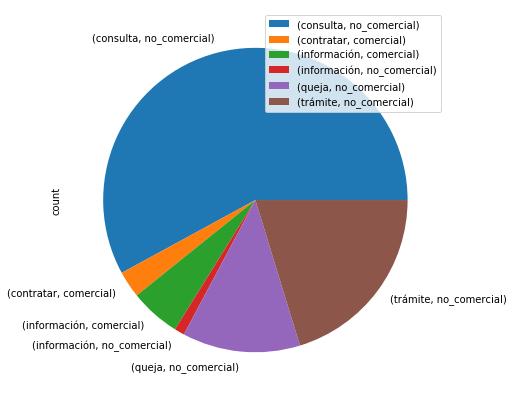

In [10]:
df_group =  (monitored_calls.groupby(['tipo', 'motivo_llamada']).count().reset_index()[['tipo',"motivo_llamada",'ucid']]).set_index(["tipo", "motivo_llamada"])
df_group.columns = [ "count"]
df_group.plot.pie(y='count', figsize=(7, 7))
display(df_group)
del(df_group)

Cargamos un fichero en el que hemos tokenizado previamente estos datos para ahorrarnos el procesamiento. Lo hacemos usando el módulo "mgmtfm" que contiene clases y funciones para simplificarnos la ejecución del proyecto. 

In [11]:
file_tokens = "/data/mgm/data/pandas/tokens_monitored_quit_commons_12112019.pkl"
clean_steps = clean.Clean()
clean_steps.load_tokens(file_tokens)
monitored_tokens = clean_steps.tokens

Found 20422 unique tokens.


Para tener una idea inicial de las llamadas que se hacen, podemos pintar una nube de palabras que nos permita visualizar de manera sencilla los términos más usados:

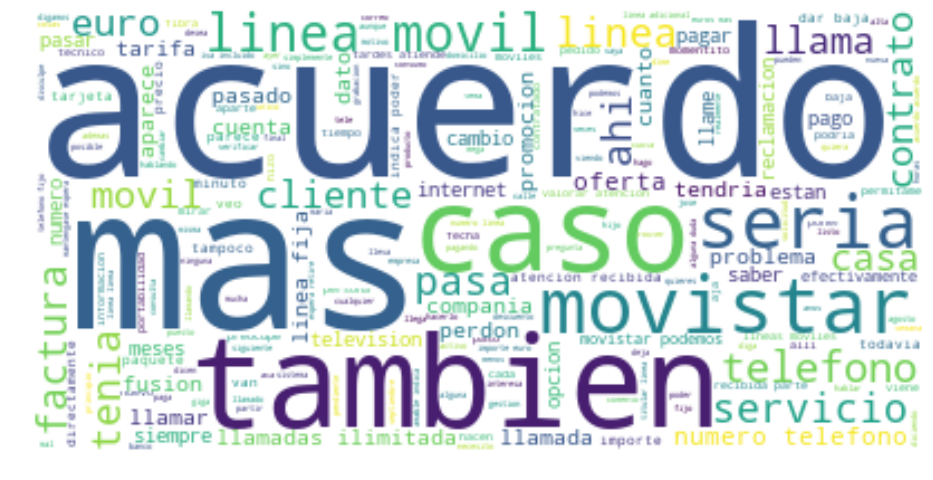

In [12]:
def plot_wordcloud(tokens, title=None):
    text = " ".join(tokens["plaintext"].apply(" ".join))
    wordcloud = WordCloud(background_color="white").generate(text)
    fig = plt.figure( figsize=(16,10) )
    if (title):
        fig.suptitle(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
plot_wordcloud(monitored_tokens)

Las palabras que nos encontramos parece que están claramente relacionadas con el servicio que se puede dar en el <i>call center</i> como "línea móvil", "número teléfono", "contrato", "oferta", "servicio"... 

Algo interesante puede ser obtener la nube de palabras por cada categoría para ver si obtenemos diferencias.




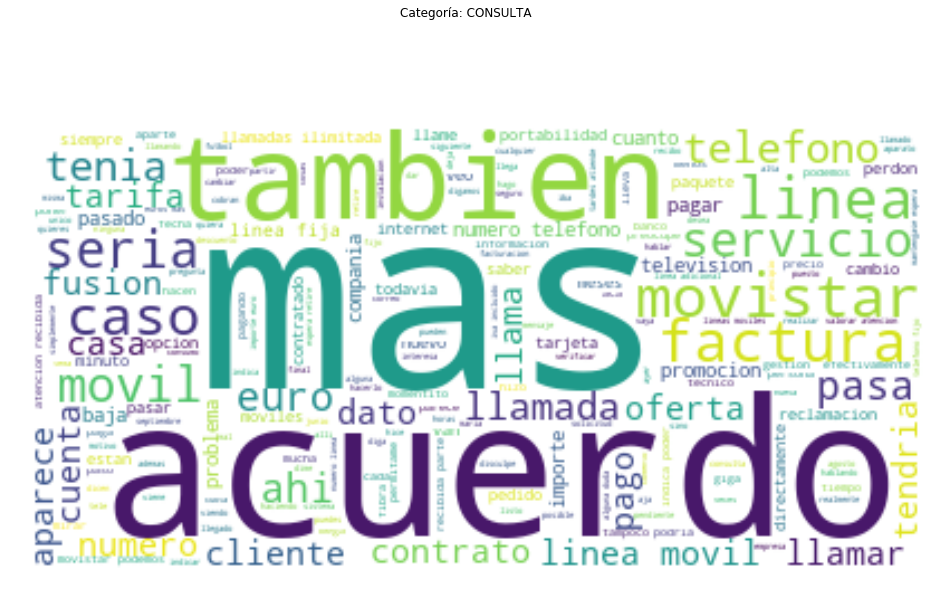

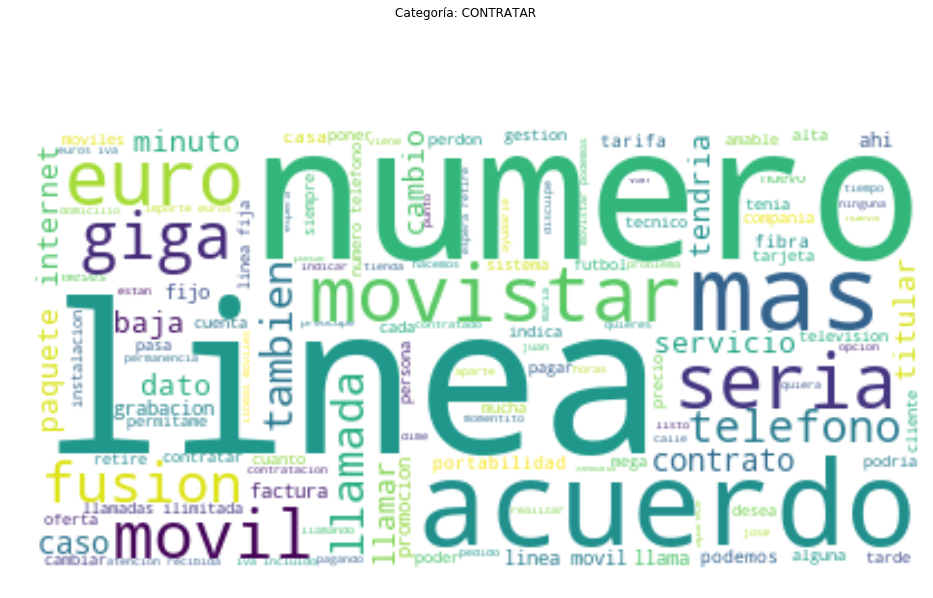

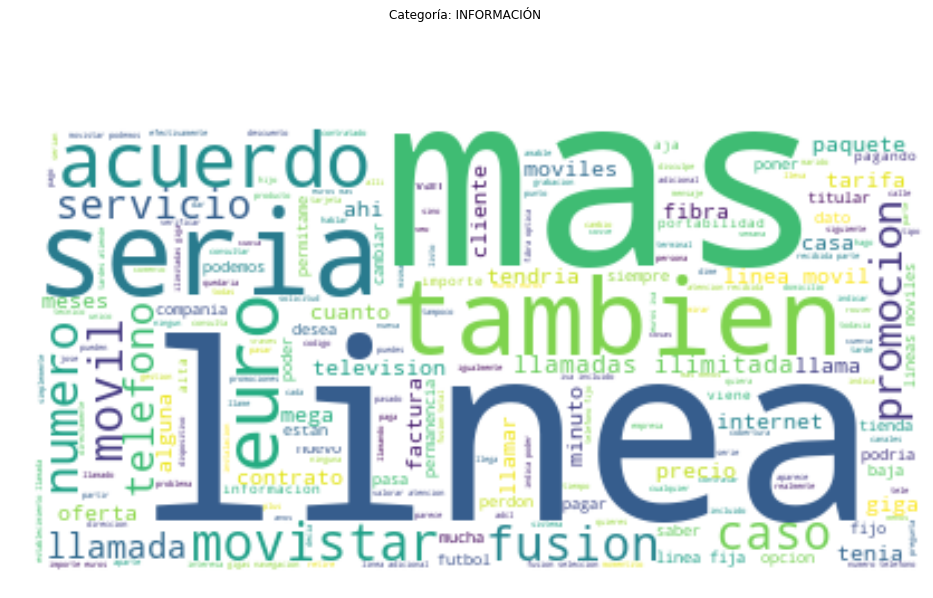

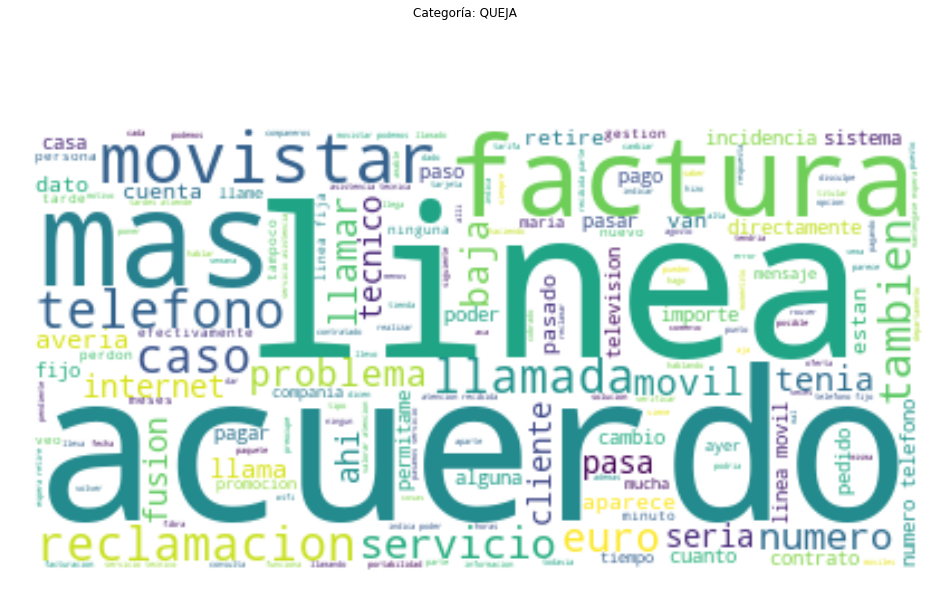

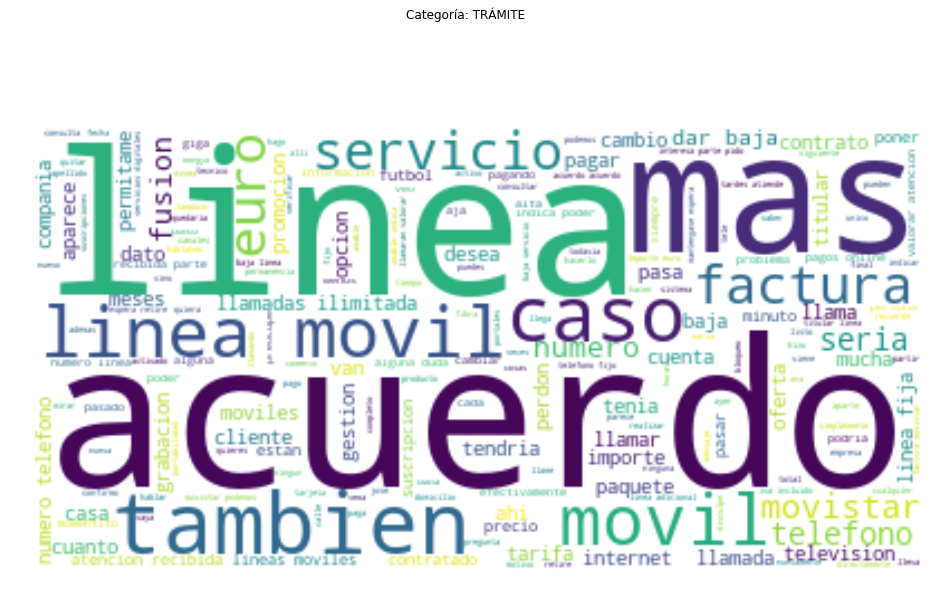

In [13]:
tipos = clean_steps.distribucion_tipos.index.tolist()

for tipo in tipos:
    tokens_cat = monitored_tokens[monitored_tokens['tipo']==tipo]
    plot_wordcloud(tokens_cat, "Categoría: " + tipo.upper() )

Vemos que efectivamente hay variaciones en las nubes de palabras de las categorías, por destacar algunas:
<ul>
<li>Vemos "línea" y "número" como palabras muy representativas a la hora de contratar.</li>
<li>Vemos "reclamación" y "incidencia" como palabras presentes en la categoría queja.</li>  
<li>En trámite nos aparece por ejemplo "dar baja".</li>
</ul>

### IVR

Realizamos el mismo ejercicio para las categorizaciones con IVR. En primer lugar mostramos su distribución:

count
tipo                 
Avería          12350
Baja            24999
Comercial      204924
Factura         67892
No Reconocido   53198
Reclamación     23802
Resto          108746

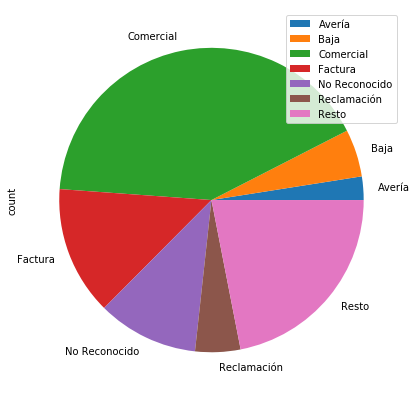

In [14]:
df_group =  (ivr_calls.groupby(['tipo']).count().reset_index()[['tipo','ucid']]).set_index("tipo")
df_group.columns = [ "count"]
df_group.plot.pie(y='count', figsize=(7, 7))
display(df_group)
del(df_group)

De nuevo cargamos los tokens, para no tener que repetir el procesamiento y mostramos la nube de palabras. 

Found 47990 unique tokens.


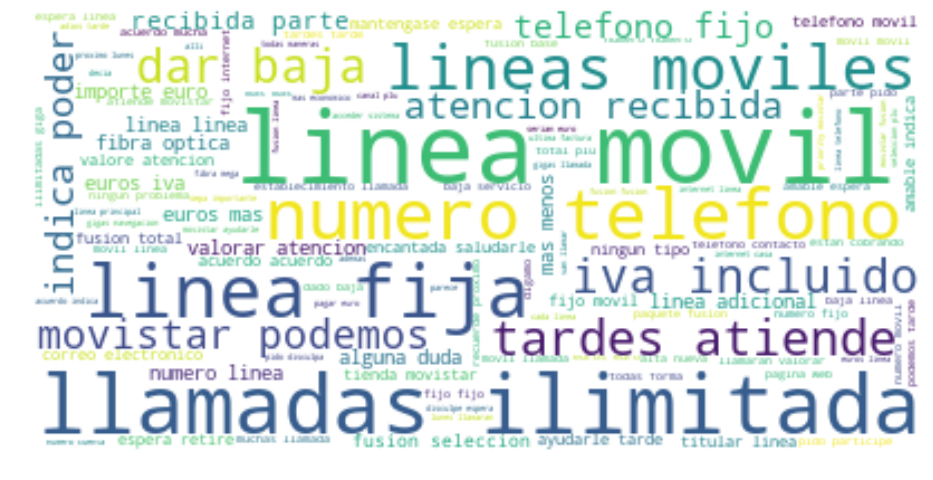

In [15]:
file_tokens = "/data/mgm/data/pandas/tokens_ivr_quit_commons_02112019.pkl"
clean_steps = clean.Clean()
clean_steps.load_tokens(file_tokens)
ivr_tokens = clean_steps.tokens
plot_wordcloud(ivr_tokens)

 Vemos que aparecen más términos al aumentar la cantidad de llamadas. Mostramos la nube de palabras por categorías.

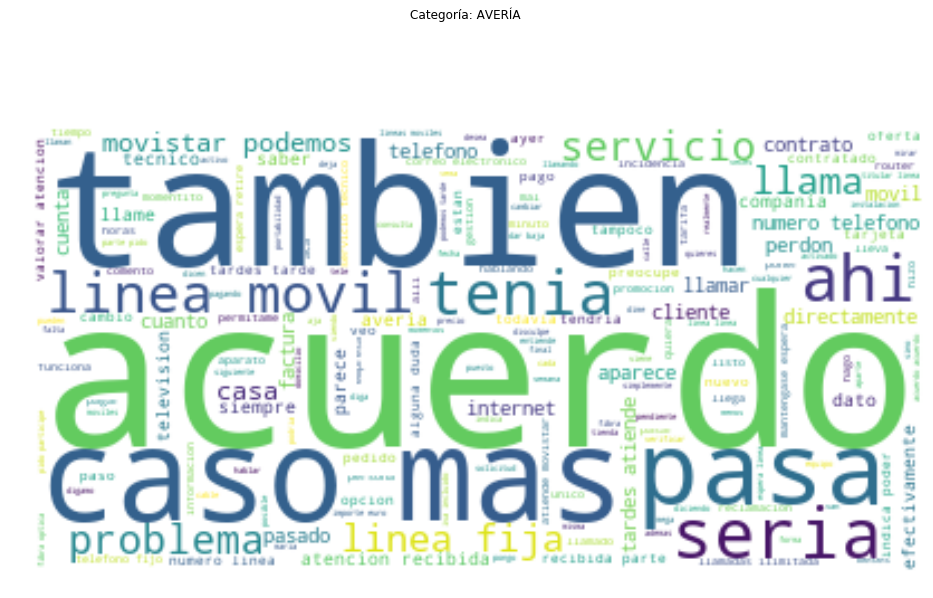

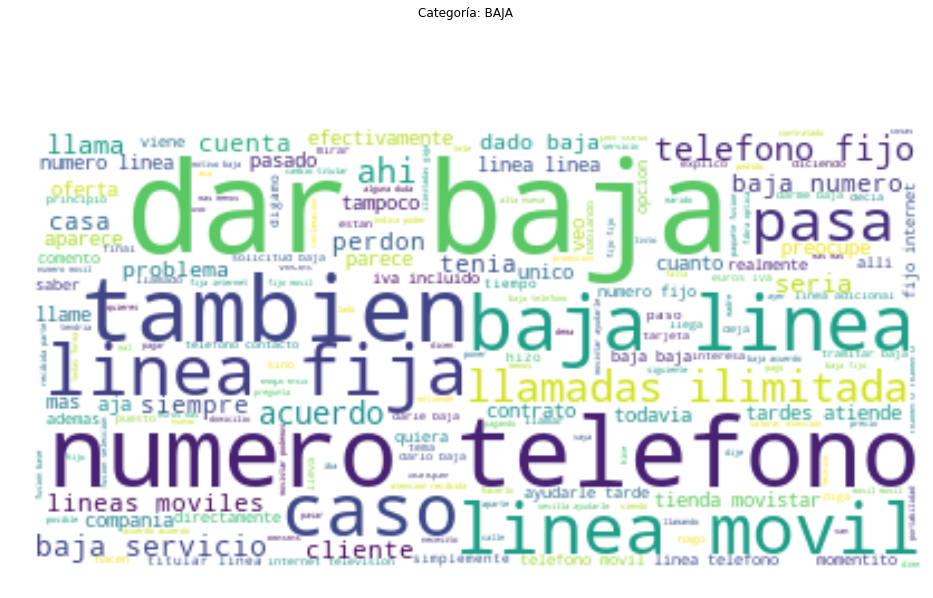

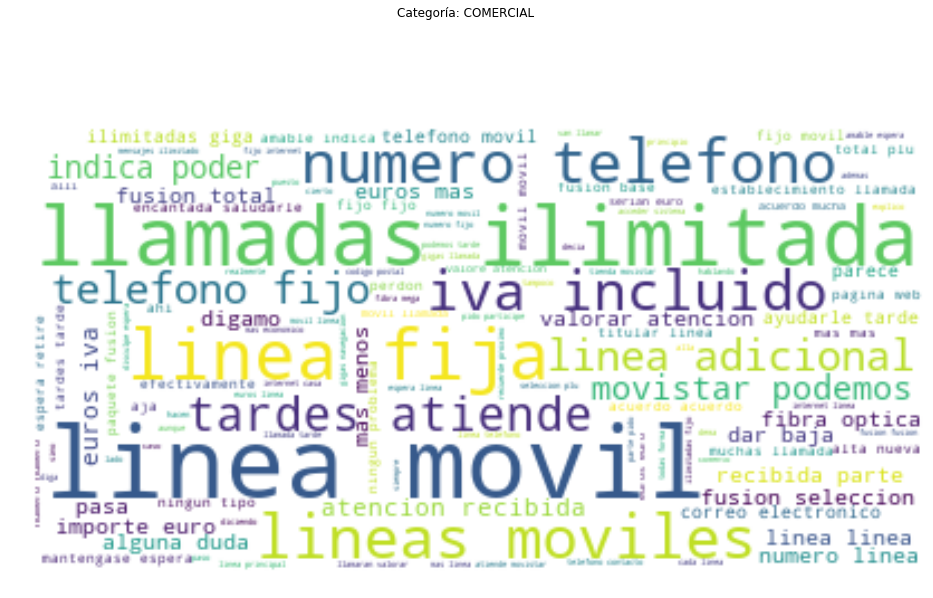

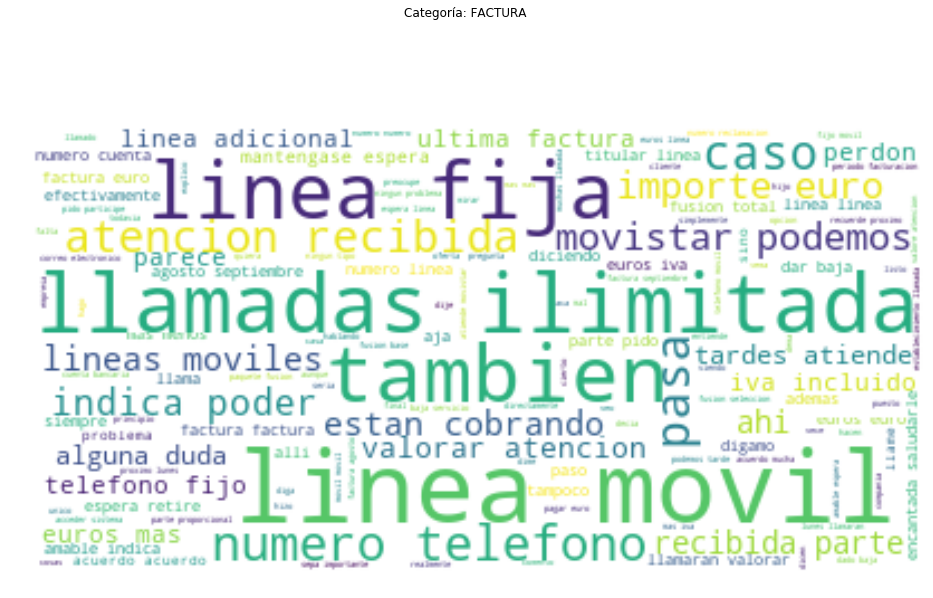

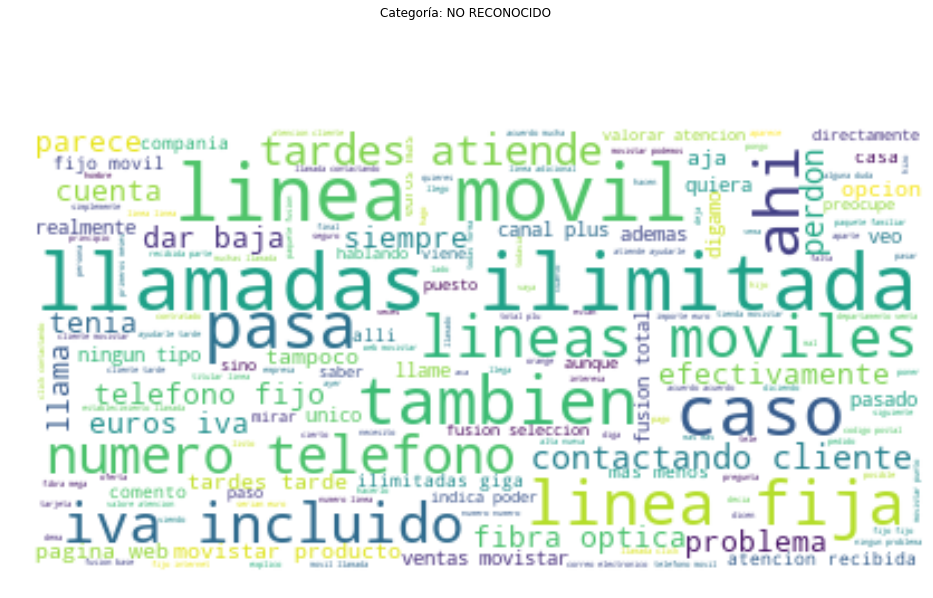

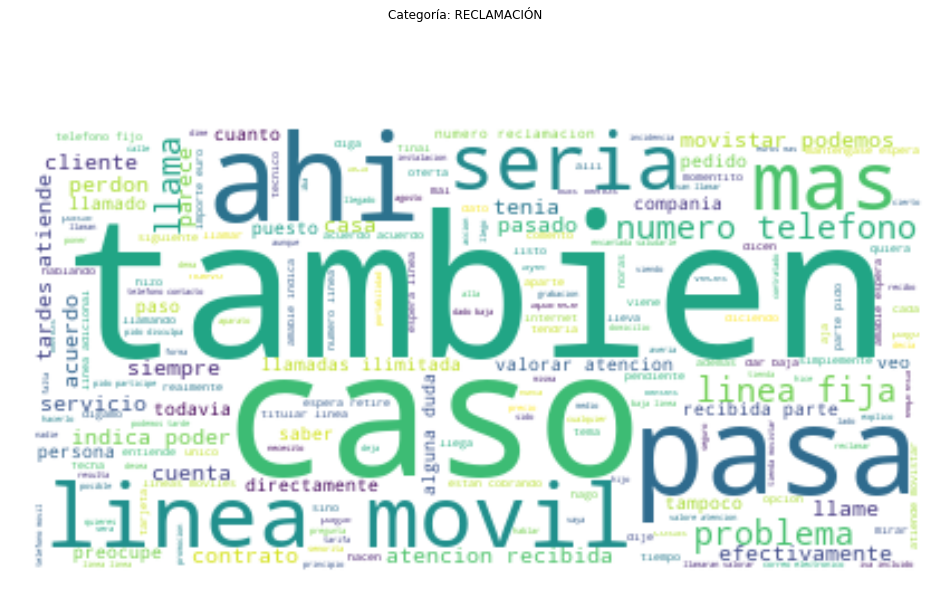

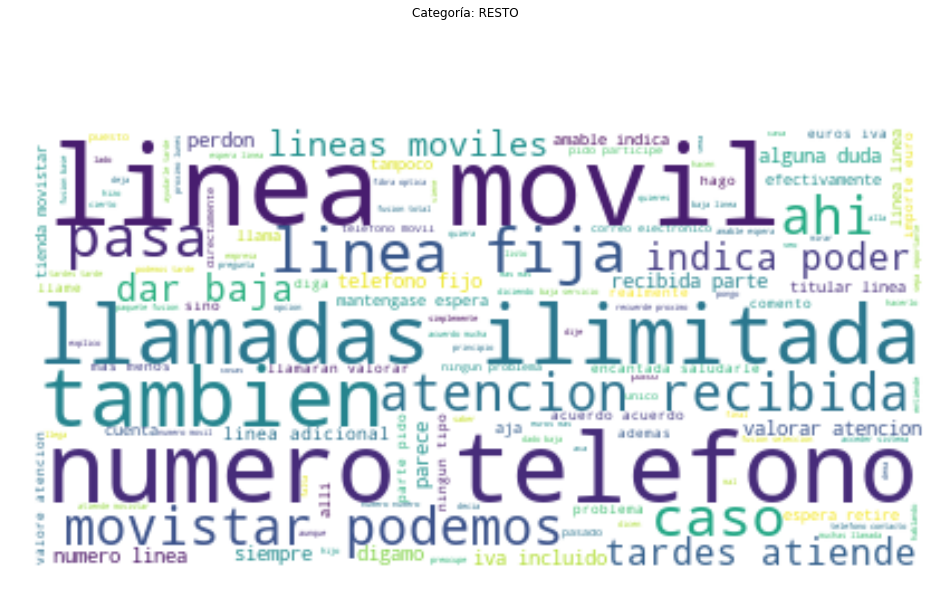

In [16]:
tipos = clean_steps.distribucion_tipos.index.tolist()

for tipo in tipos:
    tokens_cat = ivr_tokens[ivr_tokens['tipo']==tipo]
    plot_wordcloud(tokens_cat, "Categoría: " + tipo.upper() )

Las categorías aparecen algo más difusas en este caso que en el de monitorizacines. Pero sí nos encontramos por ejemplo con:

<ul>
    <li>"dar baja" en la categoría baja. </li>
    <li> "problema" y "caso" en reclamación.</li>
    <li>"estan cobrando" en factura.</li>
    <li>"avería" en avería.</li>
</ul>